# Deep Learning with PyTorch : Build a Generative Adversarial Network

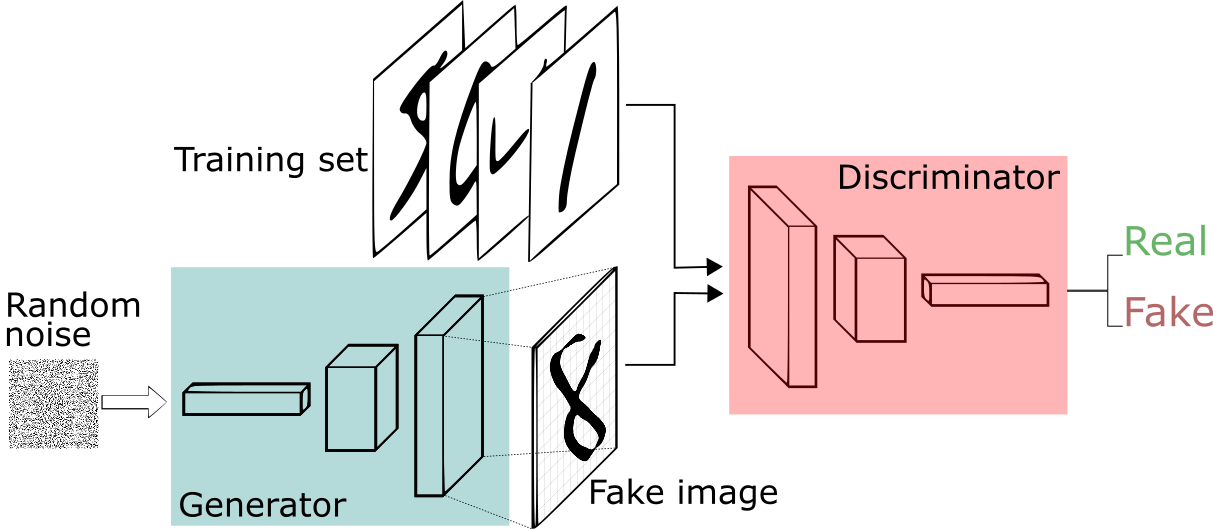

In [42]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [43]:
DEVICE = 'cuda'
BATCH_SIZE = 128
NOISE_DIM = 64

# optimizer parameters
LR = 0.0002
BETA_1 = 0.5
BETA_2 = 0.99

# training parameters
EPOCHS = 20

# Load MNIST Dataset

In [44]:
from torchvision import datasets, transforms as T

In [45]:
train_augs = T.Compose([
    T.RandomRotation((-20, 20)),
    T.ToTensor() # (h, w, c) ==> (c, h, w)
])

In [46]:
trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=train_augs)

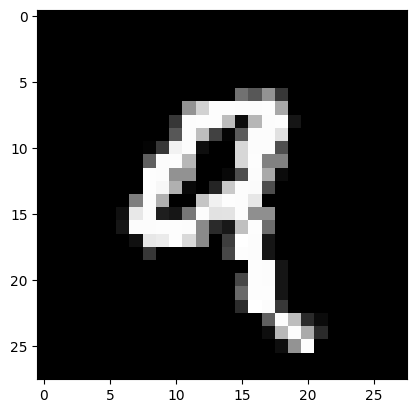

In [47]:
image, label = trainset[4]

plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [48]:
len(trainset)

60000

# Load Dataset Into Batches

In [49]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [50]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

In [51]:
len(trainloader)

469

In [52]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [53]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

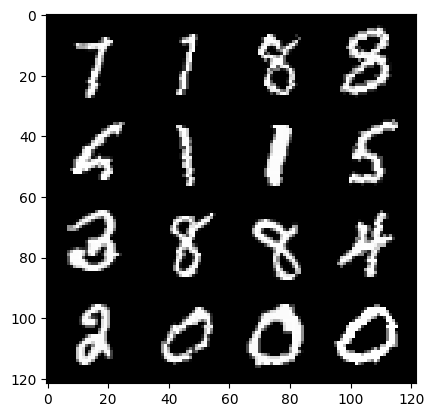

In [54]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [55]:
%%capture
#In case if torch summary is not installed

!pip install torchsummary

In [56]:
from torch import nn
from torchsummary import summary

In [57]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [58]:
def discriminator_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [59]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block1 = discriminator_block(1, 16, (3, 3), 2)
    self.block2 = discriminator_block(16, 32, (5, 5), 2)
    self.block3 = discriminator_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, images):
    x = self.block1(images)
    x = self.block2(x)
    x = self.block3(x)

    x = self.flatten(x)
    x = self.linear(x)

    return x

In [60]:
D = Discriminator().to(DEVICE)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [61]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [62]:
def generator_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [63]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block1 = generator_block(NOISE_DIM, 256, (3, 3), 2)
    self.block2 = generator_block(256, 128, (4, 4), 1)
    self.block3 = generator_block(128, 64, (3, 3), 2)

    self.block4 = generator_block(64, 1, (4, 4), 2, final_block=True)

  def forward(self, rand_noise_vec):
    # (bs, NOISE_DIM) ==> (bs, NOISE_DIM, 1, 1)
    x = rand_noise_vec.view(-1, self.noise_dim, 1, 1)

    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)

    return x

In [64]:
G = Generator(NOISE_DIM).to(DEVICE)

summary(G, input_size=(1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [65]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [66]:
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [67]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [68]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA_1, BETA_2))
G_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA_1, BETA_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.686260196064581 | G_loss : 0.6894246296587784


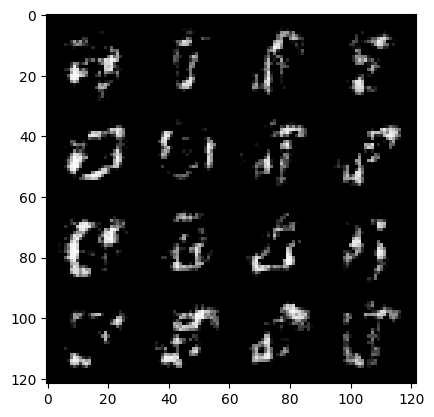

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6764723659832594 | G_loss : 0.7146449420752048


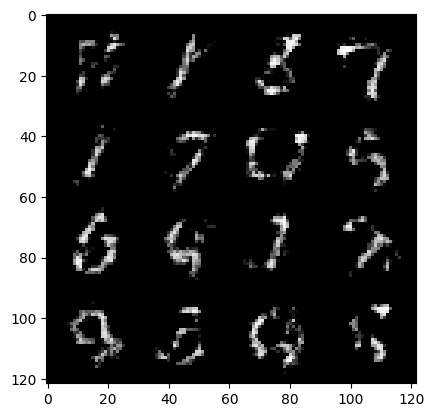

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6342159967178475 | G_loss : 0.7630433998128244


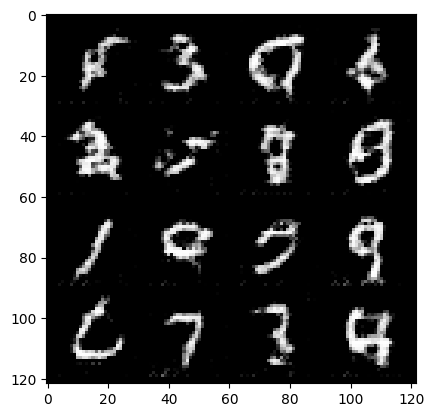

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6122751327465846 | G_loss : 0.8011411343302045


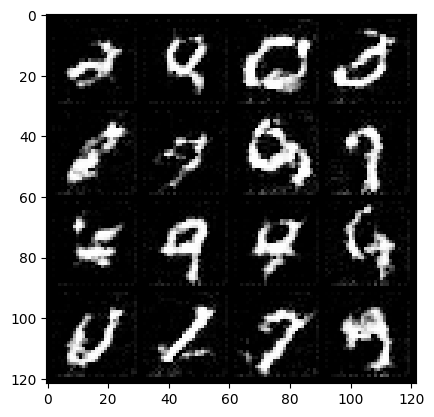

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6132742161435614 | G_loss : 0.8147431854754369


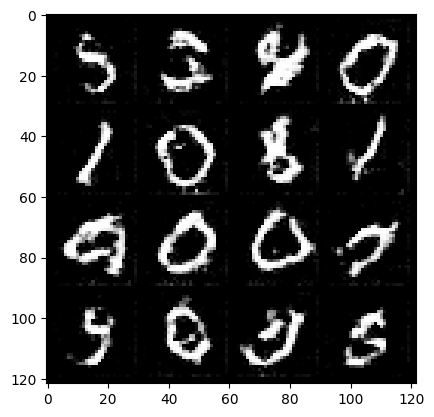

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6176920923342837 | G_loss : 0.8250245111329215


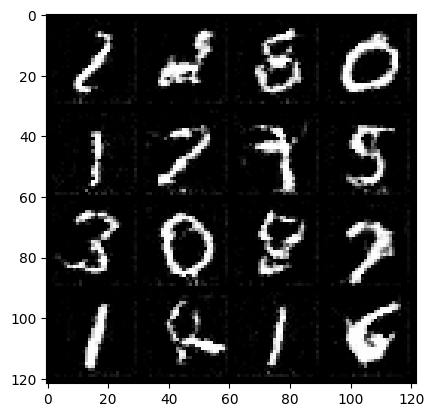

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6222348215737576 | G_loss : 0.8313079877957098


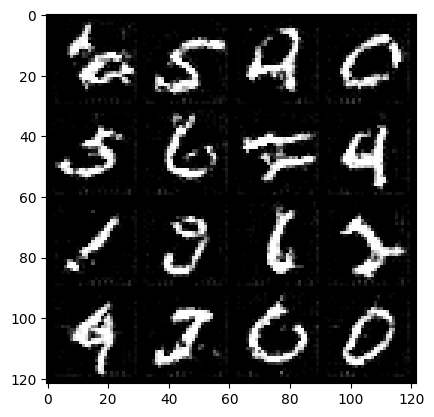

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6251402291407717 | G_loss : 0.8367183740967626


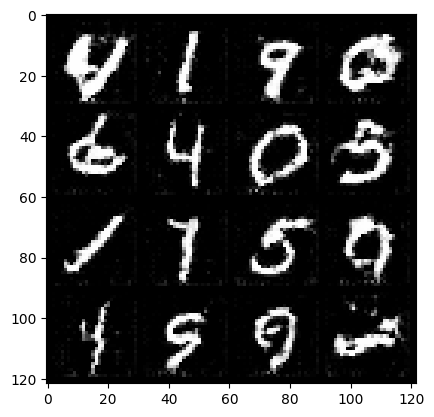

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6286460011244328 | G_loss : 0.8386521077613587


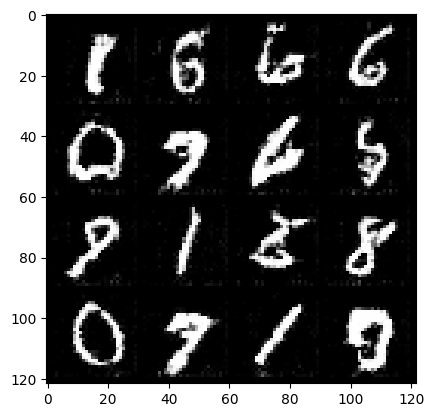

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6323002388736586 | G_loss : 0.840073360563087


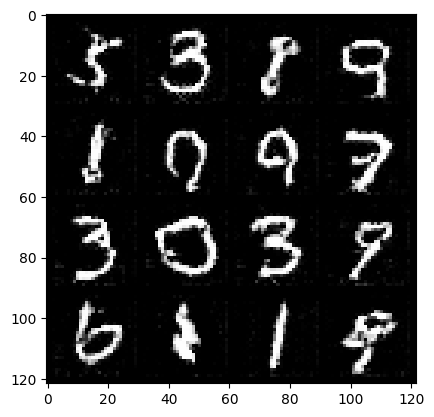

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.636801439307646 | G_loss : 0.8369576918290876


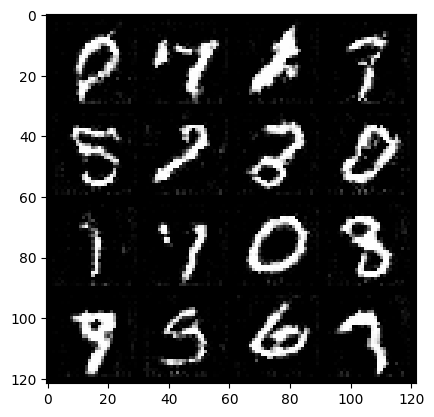

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6401284324334883 | G_loss : 0.8359073786847373


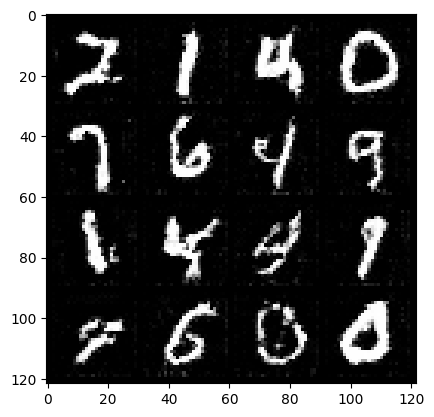

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6435012315382073 | G_loss : 0.8327355659338457


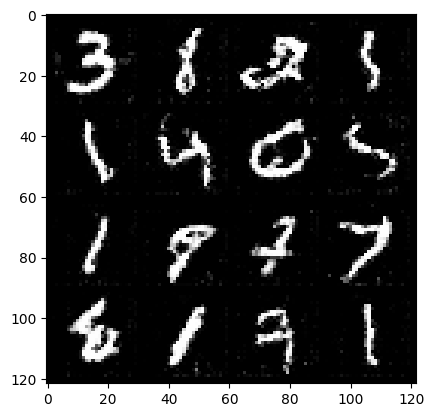

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6457687928986702 | G_loss : 0.8313657013592182


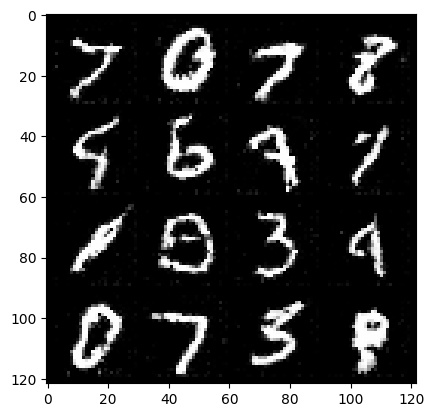

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6470711809485706 | G_loss : 0.8294872881761238


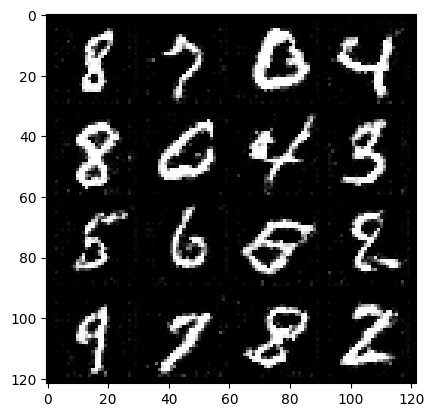

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.650292370619296 | G_loss : 0.8276568607989151


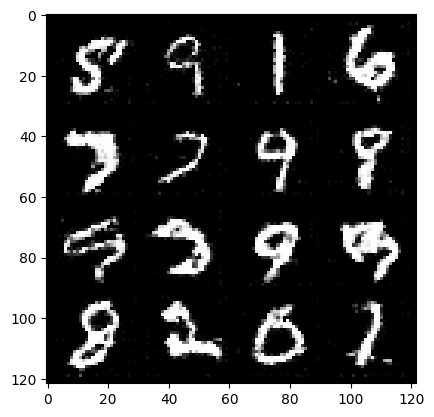

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6515852836911866 | G_loss : 0.82575815115402


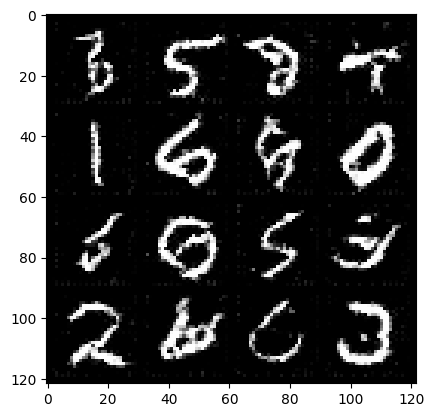

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6528093248033828 | G_loss : 0.8235842915994527


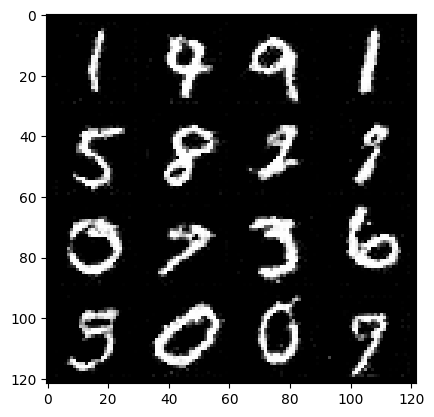

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6524766649264516 | G_loss : 0.8242932165355317


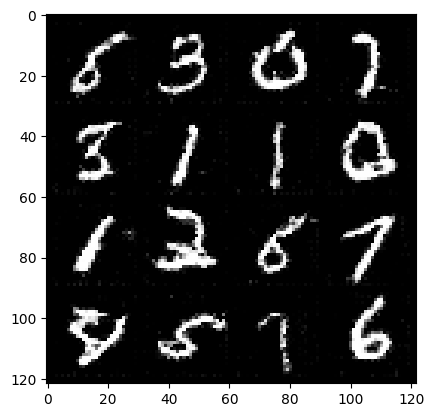

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6551624828818511 | G_loss : 0.8218575785917513


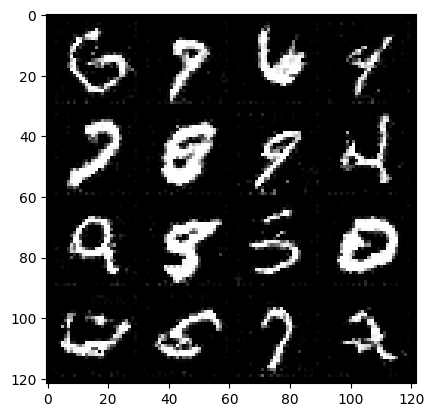

In [69]:
for i in range(EPOCHS):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_images, _ in tqdm(trainloader):
    real_images = real_images.to(DEVICE)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)

    # find loss and update weights for D
    D_opt.zero_grad()

    fake_img = G(noise)
    disc_fake_pred = D(fake_img.detach())
    disc_fake_loss = fake_loss(disc_fake_pred)

    disc_real_pred = D(real_images)
    disc_real_loss = real_loss(disc_real_pred)

    D_loss = (disc_fake_loss + disc_real_loss) / 2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss and update weights for G
    G_opt.zero_grad()

    fake_img = G(noise)
    disc_fake_pred = D(fake_img)
    G_loss = real_loss(disc_fake_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print(f"Epoch : {i+1} | D_loss : {avg_d_loss} | G_loss : {avg_g_loss}")
  show_tensor_images(fake_img)

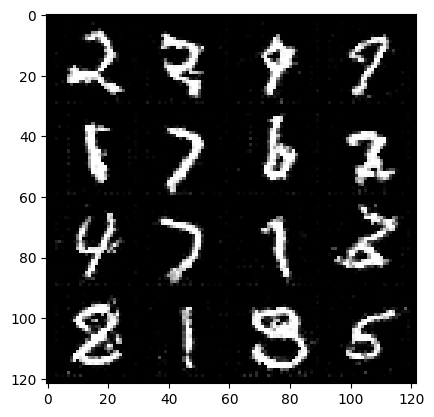

In [70]:
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(BATCH_SIZE, NOISE_DIM, device = DEVICE)
generated_image = G(noise)

show_tensor_images(generated_image)